# Setup

In [ ]:
include("../lna.jl")
using DifferentialEquations, StatsBase, Plots, Distributions, LaTeXStrings, DataFrames, CSV, ProgressBars


function reaction(n)
    "
    ρ_m$(n), 0 --> M$(n)
    δ_m$(n), M$(n) --> 0
    σ_b$(n), M$(n) + R --> MR$(n)
    δ_u$(n), MR$(n) --> M$(n) + R
    ρ_p$(n), MR$(n) --> M$(n) + P$(n) + R
    δ_mr$(n), MR$(n) --> 0
    δ_p$(n), P$(n) --> 0
    "
end

function endstring(n)
    cumulative_string = "end ρ_r δ_r "
    for i in 1:n
        cumulative_string = string(cumulative_string, "ρ_m$(i) δ_m$(i) σ_b$(i) δ_u$(i) ρ_p$(i) δ_mr$(i) δ_p$(i) ")
    end
    cumulative_string
end

function generate_rn(n)
    rnstring = "rn = @reaction_network begin
        ρ_r, 0 --> R
        δ_r, R --> 0
    "
    for i in 1:n
        rnstring = string(rnstring, reaction(i))
    end
    rnstring = string(rnstring, endstring(n))
    rnexpression = Base.Meta.parse(rnstring)
    eval(rnexpression)
end

function generate_propensities(n)
    rand(Float64, (6*n+2))
end

function relative_error(true_val, approx_val)
    map(abs, 1 .- approx_val./true_val)
end

# Valid always
function FF_single_gene_ribosome(props)
    k1 = props[3]
    k2 = props[4]
    k3 = props[5] - props[6] + props[7] # What should this really be?
    k6 = props[2]
    k7 = props[1]
    return 1 + k3*k7/(k6*(k2+k6))+k1*k3/(2*k2*k6)
end

# Valid if k2>>k6
function FF_single_gene_ribosome_approx(props)
    k1 = props[3]
    k2 = props[4]
    k3 = props[5]/props[6] + props[7]/ props[8] # What should this really be?
    k6 = props[2]
    k7 = props[1]
    return 1 + k3*k7/(k6*k2)+k1*k3/(2*k2*k6)
end

function FF_single_gene_ribosome_sim(props, p)
    k1 = props[3]
    k2 = props[4]
    k6 = props[2]
    k7 = props[1]
    k3 = p*k6*k2*k6/(k1*k7)
    return 1 + k3*k7/(k6*(k2+k6))+k1*k3/(2*k2*k6)
end

# Valid if k2>>k6
function FF_single_gene_ribosome_approx_sim(props, p)
    k1 = props[3]
    k2 = props[4]
    k6 = props[2]
    k7 = props[1]
    k3 = p*k6*k2*k6/(k1*k7)
    return 1 + k3*k7/(k6*k2)+k1*k3/(2*k2*k6)
end

function FF_can_approx_sim(props, p, r)
    k1 = props[3]
    k2 = props[4]
    k6 = props[2]
    k7 = props[1]
    k3 = p*k6*k2*k6/(k1*k7) * r
    return 1 + k3*k7/(k2*k6)
end

FF_can_approx_sim (generic function with 1 method)

# Verifying the LNA solution

In [3]:
N = 10

rn = generate_rn(N)

ps = [50., .1]
    
for i in 1:N
    ps = vcat(ps, [1.5, .1, .2, .1, .5, .1, .1])
end

prob = LNAProblem(rn, zeros(Int, 3*N+3), ps)

sol = solve(prob)

lnameans = mean(sol)
lnacovs = StatsBase.cov(sol)

initial_values = map(Int64, map(ceil, lnameans))

prob = DiscreteProblem(rn, initial_values, (0, 5000000.),  ps)
jump_prob = JumpProblem(rn, prob, Direct(), save_positions=(false, false))

sol = solve(jump_prob, SSAStepper(), saveat=1.0)

protein_counts = map(x -> x[4], sol.u)

LoadError: InterruptException:

In [4]:
histogram(protein_counts, nbins=maximum(protein_counts), norm=true, label="Stochastic Simulation Algorithm")

prot_mean = lnameans[4]
prot_var = lnacovs[4,4]

p = prot_mean/prot_var
r = prot_var*p^2/(1-p)

step=2
nb = NegativeBinomial(r,p)
xs = [minimum(protein_counts):step:maximum(protein_counts)]
ys = Distributions.pdf(nb, xs)

histogram(
    protein_counts, 
    nbins=maximum(protein_counts), 
    norm=true, 
    label="Simulation",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

scatter!(
    xs,
    ys, 
    label="LNA Approximation", 
    title = "Protein Copy Number for System with $N Genes", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    markersize=5,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false
)

LoadError: UndefVarError: protein_counts not defined

In [5]:
savefig("../../data/figures-for-paper/protein_copy_number_$(N)_genes.svg")

LoadError: No current plot/subplot

In [6]:
mrna_counts = map(x -> x[2], sol.u)
histogram(mrna_counts, 
    nbins=maximum(mrna_counts), 
    norm=true, 
    label="Stochastic Simulation Algorithm",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

m_mean = lnameans[2]
m_var = lnacovs[2,2]

p = m_mean/m_var
r = m_var*p^2/(1-p)

nb = NegativeBinomial(r,p)
xs = [0:1:maximum(mrna_counts)]
ys = Distributions.pdf(nb, xs)
scatter!(
    xs,
    ys,
    label="LNA Approximation", 
    title = "mRNA Copy Number for System with $(N) Genes",
    xlabel=L"m",
    ylabel=L"P(m)",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false
)

LoadError: BoundsError

In [7]:
savefig("../../data/figures-for-paper/mrna_copy_number_$(N)_genes.svg")

LoadError: No current plot/subplot

# Comparison of Full and Reduced Models

In [9]:
xs = 1:10:100
ffs_full = zeros(length(xs))
ffs_red = zeros(length(xs))
ffs_red_approx = zeros(length(xs))

for i in 1:length(xs)
    N = xs[i]
    rn = generate_rn(N)

    ps = [50., .1]

    for j in 1:N
        ps = vcat(ps, [1.5, .1, .2, .1, .5, .1, .1])
    end

    prob = LNAProblem(rn, zeros(Int, 3*N+3), ps)

    sol = solve(prob)

    lnameans = mean(sol)
    lnacovs = StatsBase.cov(sol)

    ffs_full[i] = lnacovs[4,4]/lnameans[4]
    ffs_red[i] = FF_single_gene_ribosome_sim(ps, lnameans[4])
    ffs_red_approx[i] = FF_single_gene_ribosome_approx_sim(ps, lnameans[4])
end

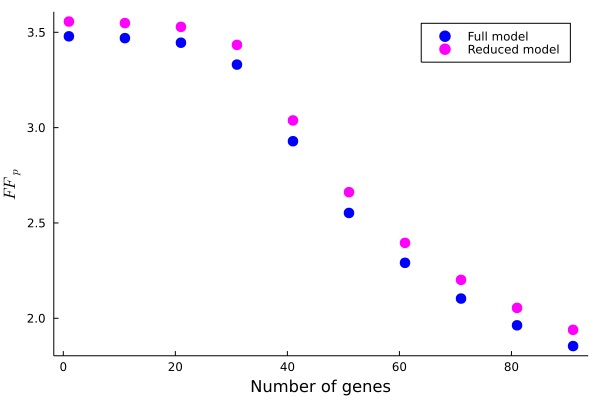

In [10]:
scatter(
    xs,
    ffs_full,
    label="Full model",
    markersize=6,
    markercolor=RGBA(0/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(0/255, 0/255, 255/255, 255/255),
)

scatter!(
    xs,
    ffs_red,
    label="Reduced model",
    xlabel="Number of genes",
    ylabel=L"FF_{p}",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false)

In [11]:
savefig("../../data/figures-for-paper/full_model_verses_reduced_model_$(N)_genes.svg")

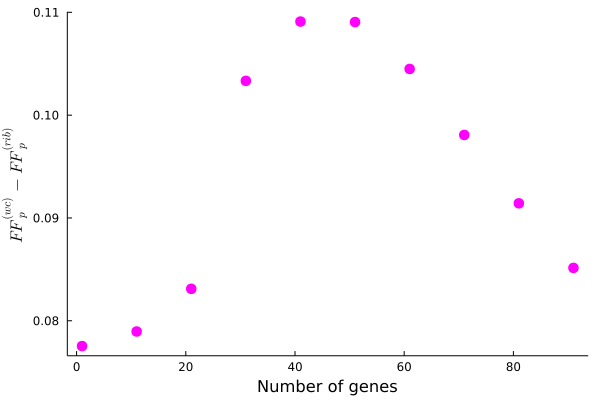

In [12]:
scatter(
    xs,
    ffs_red-ffs_full,
    ylabel=L"FF_p^{(wc)} - FF_p^{(rib)}",
    xlabel="Number of genes",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    legend=false,
    grid=false
)

In [13]:
savefig("../../data/figures-for-paper/residuals_full_model_ribosome_model_$(N)_genes.svg")

# Choosing Realistic Parameters

In [14]:
# Load data from schwannhauser
exp_data = DataFrame(CSV.File("../../data/experimental_data_sanitised.csv"))
dropmissing!(exp_data)
names(exp_data)

7-element Vector{String}:
 "id"
 "pNumber"
 "mNumber"
 "alpha"
 "beta"
 "mHalfLife"
 "pHalfLife"

In [15]:
median(exp_data[!, :pNumber])

41913.32

In [16]:
mean(exp_data[!, :pNumber])

475168.0025453261

In [17]:
sort(exp_data, [:pNumber])[50, :]

,id,pNumber,mNumber,alpha,beta,mHalfLife,pHalfLife
,String,Float64,Float64,Float64,Float64,Float64,Float64
50,IPI00136246.1,343.98,17.43,2.0,1.57,8.54,39.97


In [18]:
N = 10

rn = generate_rn(N)

ps = [50., .1]
    
for i in 1:N
    ps = vcat(
        ps, 
        [
            1.9, # mRNA creation
            log(2)/8.54, # mRNA degredation
            .01, # binding to polysome
            0.001, # unbinding from polysome
            5.0, # translation,
            .1, # monosome decay
            .1 # protein decay
        ]
    )
end


prob = LNAProblem(rn, zeros(Int, 3*N+3), ps)

sol = solve(prob)

lnameans = mean(sol)
lnacovs = StatsBase.cov(sol)

initial_values = map(Int64, map(ceil, lnameans))

prob = DiscreteProblem(rn, initial_values, (0, 10000000.),  ps)
jump_prob = JumpProblem(rn, prob, Direct(), save_positions=(false, false))

sol = solve(jump_prob, SSAStepper(), saveat=1.0)
mrna_counts = map(x -> x[2], sol.u)
monosome_counts = map(x -> x[3], sol.u)
protein_counts = map(x -> x[4], sol.u)
ribosome_counts = map(x -> x[1], sol.u)

print("
    mRNA counts: $(mean(mrna_counts + monosome_counts))\n
    unbound mRNA counts: $(mean(mrna_counts))\n
    protein counts: $(mean(protein_counts))\n
    ribosomes counts: $(mean(ribosome_counts))\n
    ")


    mRNA counts: 21.226460977353902

    unbound mRNA counts: 11.822989717701029

    protein counts: 470.1744210825579

    ribosomes counts: 406.0090840990916

    

In [19]:
mean(mrna_counts + monosome_counts)

21.226460977353902

In [20]:
mean(mrna_counts)

11.822989717701029

In [21]:
mean(protein_counts)

470.1744210825579

In [22]:
mean(ribosome_counts)

406.0090840990916

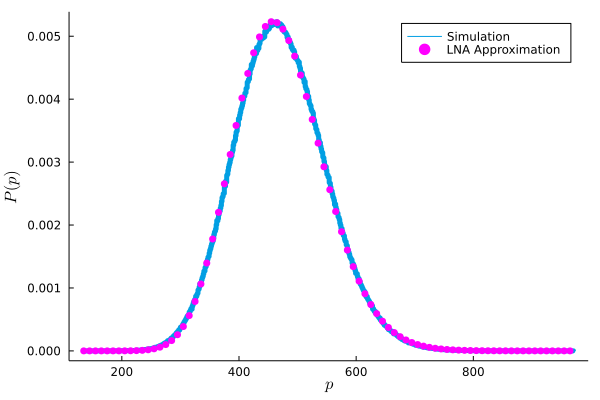

In [23]:
prot_mean = lnameans[4]
prot_var = lnacovs[4,4]

p = prot_mean/prot_var
r = prot_var*p^2/(1-p)

nb = NegativeBinomial(r,p)
step = 10
xs = [minimum(protein_counts):step:maximum(protein_counts)]
ys = Distributions.pdf(nb, xs)

histogram(
    protein_counts, 
    nbins=maximum(protein_counts), 
    norm=true, 
    label="Simulation",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

scatter!(
    xs,
    ys, 
    label="LNA Approximation", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = RGBA(255/255, 0/255, 255/255, 255/255),
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false,
    markersize=4
)

In [24]:
savefig("../../data/figures-for-paper/protein_count_$(N)_genes_IPI00136246.svg")

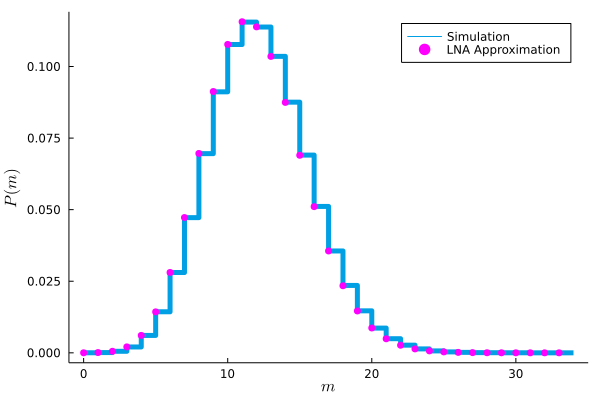

In [25]:
mrna_mean = lnameans[2]
mrna_var = lnacovs[2,2]

p = mrna_mean/mrna_var
r = mrna_var*p^2/(1-p)

nb = NegativeBinomial(r,p)
step = 1
xs = [minimum(mrna_counts):step:maximum(mrna_counts)]
ys = Distributions.pdf(nb, xs)


histogram(
    mrna_counts, 
    nbins=maximum(mrna_counts), 
    norm=true, 
    label="Simulation",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

scatter!(
    xs,
    ys, 
    label="LNA Approximation", 
    xlabel=L"m", 
    ylabel=L"P(m)",
    color = RGBA(255/255, 0/255, 255/255, 255/255),
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false,
    markersize=4
)

In [26]:
savefig("../../data/figures-for-paper/mrna_count_$(N)_genes_IPI00136246.svg")

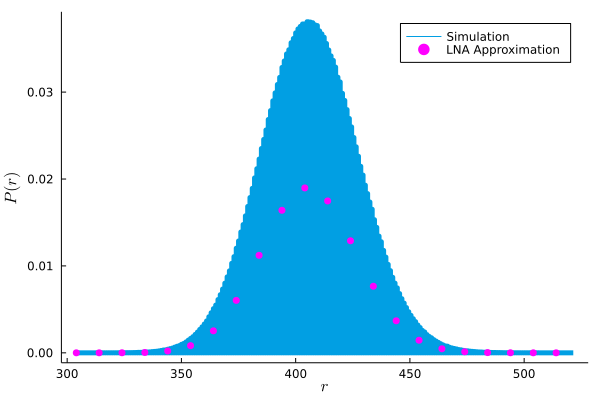

In [27]:
rib_counts = ribosome_counts
rib_mean = lnameans[1]
rib_var = lnacovs[1,1]

p = rib_mean/rib_var
r = rib_var*p^2/(1-p)

nb = NegativeBinomial(r,p)
step = 10
xs = [minimum(rib_counts):step:maximum(rib_counts)]
ys = Distributions.pdf(nb, xs)


histogram(
    rib_counts, 
    nbins=400, 
    norm=true, 
    label="Simulation",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

scatter!(
    xs,
    ys, 
    label="LNA Approximation", 
    xlabel=L"r", 
    ylabel=L"P(r)",
    color = RGBA(255/255, 0/255, 255/255, 255/255),
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false,
    markersize=4
)

In [28]:
savefig("../../data/figures-for-paper/rib_count_$(N)_genes_IPI00136246.svg")

# Comparing Differences for Large Number of Genes

The first idea here is to use the IPI00136246 gene and have N perturbed copies. The total number of ribosomes will need to be much larger than the number of proteins.

In [29]:
N = 151
xs = 1:10:N
ffs_full = zeros(length(xs))
ffs_red = zeros(length(xs))
ffs_red_approx = zeros(length(xs))

p_mean_full = zeros(length(xs))
p_mean_red = zeros(length(xs))

for i in ProgressBar(1:length(xs))
    N = xs[i]
    rn = generate_rn(N)

    
    ps = [50., .1]
    for i in ProgressBar(1:N)
        ps = vcat(
            ps, 
            [
                1.9, # mRNA creation
                log(2)/8.54, # mRNA degredation
                .01, # binding to polysome
                0.001, # unbinding from polysome
                5.0, # translation,
                .1, # monosome decay
                .1 # protein decay
            ]
        )
        flush(stdout)
    end


    prob = LNAProblem(rn, zeros(Int, 3*N+3), ps)

    sol = solve(prob)

    lnameans = mean(sol)
    lnacovs = StatsBase.cov(sol)
    

    ffs_full[i] = lnacovs[4,4]/lnameans[4]
    ffs_red[i] = FF_single_gene_ribosome_sim(ps, lnameans[4])
    ffs_red_approx[i] = FF_single_gene_ribosome_approx_sim(ps, lnameans[4])
    
    p_mean_full[i] = lnameans[4]
end

0.0%┣                                               ┫ 0/16 [00:00<00:-1, -0s/it]
0.0%┣                                                ┫ 0/1 [00:00<00:00, -0s/it]
100.0%┣██████████████████████████████████████████┫ 1/1 [00:00<Inf:Inf, InfGs/it]
100.0%┣██████████████████████████████████████████┫ 1/1 [00:00<Inf:Inf, InfGs/it]
6.2%┣██▊                                        ┫ 1/16 [00:00<Inf:Inf, InfGs/it]
0.0%┣                                               ┫ 0/11 [00:00<00:-1, -0s/it]
9.1%┣████                                       ┫ 1/11 [00:00<Inf:Inf, InfGs/it]
100.0%┣███████████████████████████████████████████┫ 11/11 [00:00<00:00, 199it/s]
12.5%┣█████▉                                         ┫ 2/16 [00:01<00:07, 2it/s]
0.0%┣                                               ┫ 0/21 [00:00<00:-1, -0s/it]
4.8%┣██                                         ┫ 1/21 [00:00<Inf:Inf, InfGs/it]
100.0%┣███████████████████████████████████████████┫ 21/21 [00:00<00:00, 398it/s]
18.8%┣████████▉             

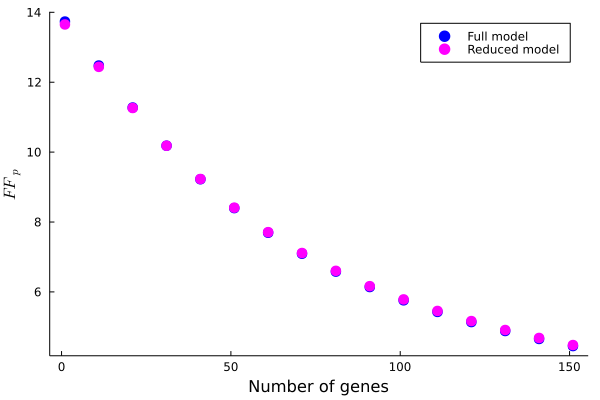

In [30]:
scatter(
    xs,
    ffs_full,
    label="Full model",
    markersize=6,
    markercolor=RGBA(0/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(0/255, 0/255, 255/255, 255/255),
)

scatter!(
    xs,
    ffs_red,
    label="Reduced model",
    xlabel="Number of genes",
    ylabel=L"FF_{p}",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false
)

In [31]:
savefig("../../data/figures-for-paper/fano_factor_$(N)_copies_gene_IPI00136246.svg")

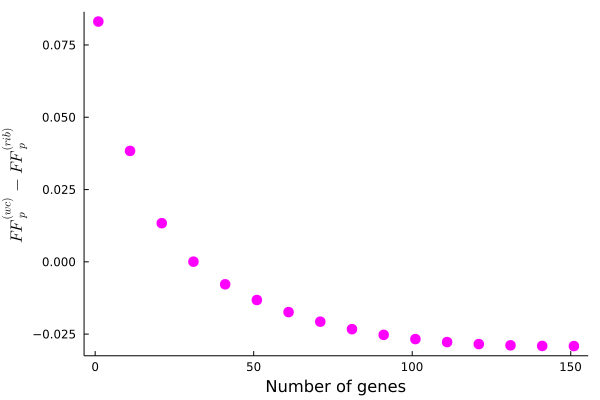

In [32]:
scatter(
    xs,
    ffs_full-ffs_red,
    ylabel=L"FF_p^{(wc)} - FF_p^{(rib)}",
    xlabel="Number of genes",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    legend=false,
    grid=false
)

In [33]:
savefig("../../data/figures-for-paper/fano_factor_difference_$(N)_copies_gene_IPI00136246.svg")

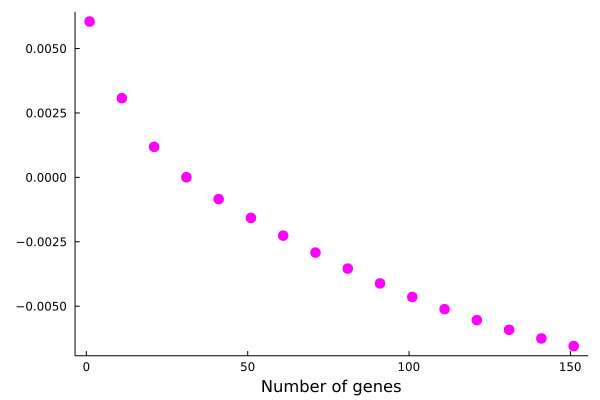

ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error


In [34]:
scatter(
    xs,
    (ffs_full .- ffs_red) ./ ffs_full,
    ylabel=L"\left(FF_p^{(wc)} - FF_p^{(rib)\right)/FF_p^{(wc)}",
    xlabel="Number of genes",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    legend=false,
    grid=false
)

In [35]:
savefig("../../data/figures-for-paper/fano_factor_rel_error_$(N)_copies_gene_IPI00136246.svg")

ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error


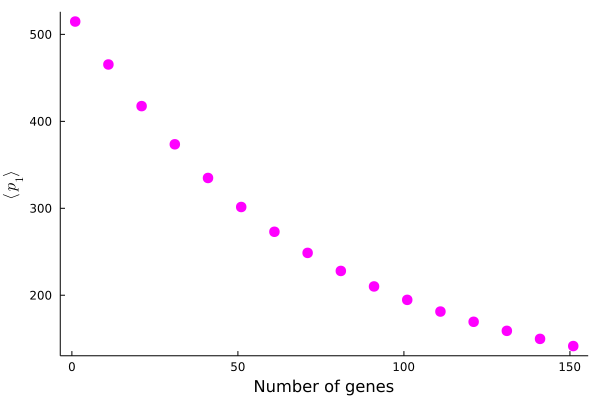

In [36]:
scatter(
    xs,
    p_mean_full,
    ylabel=L"\langle p_1 \rangle",
    xlabel="Number of genes",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    legend=false,
    grid=false
)

In [37]:
savefig("../../data/figures-for-paper/protein_copy_number_$(N)_copies_gene_IPI00136246.svg")

This assumes that the rate parameters are "real" variables which are independent of the number of genes. In reality the single gene model should have different inferred parameters which produce the same measured quantities, ie the gene number and decay rate. Since the decay rate is measurable we can keep those variables the same and only have to infer the protein constants.

## Keeping ribosome-gene ratio constant

In [38]:
N = 61
xs = 1:10:N
ffs_full = zeros(length(xs))
ffs_red = zeros(length(xs))
ffs_red_approx = zeros(length(xs))

p_mean_full = zeros(length(xs))
p_mean_red = zeros(length(xs))

for i in ProgressBar(1:length(xs))
    N = xs[i]
    rn = generate_rn(N)

    
    ps = [50. * N, .1]
    for j in 1:N
        ps = vcat(
            ps, 
            [
                1.9, # mRNA creation
                log(2)/8.54, # mRNA degredation
                .01, # binding to polysome
                0.001, # unbinding from polysome
                5.0, # translation,
                .1, # monosome decay
                .1 # protein decay
            ]
        )
    end


    prob = LNAProblem(rn, zeros(Int, 3*N+3), ps)

    sol = solve(prob)

    lnameans = mean(sol)
    lnacovs = StatsBase.cov(sol)
    

    ffs_full[i] = lnacovs[4,4]/lnameans[4]
    ffs_red[i] = FF_single_gene_ribosome_sim(ps, lnameans[4])
    ffs_red_approx[i] = FF_single_gene_ribosome_approx_sim(ps, lnameans[4])
    
    p_mean_full[i] = lnameans[4]
end

0.0%┣                                                ┫ 0/7 [00:00<00:00, -0s/it]
14.3%┣██████▏                                    ┫ 1/7 [00:00<Inf:Inf, InfGs/it]
28.6%┣█████████████▊                                  ┫ 2/7 [00:00<00:02, 3it/s]
42.9%┣████████████████████▋                           ┫ 3/7 [00:02<00:05, 1s/it]
57.1%┣███████████████████████████▍                    ┫ 4/7 [00:08<00:08, 3s/it]
71.4%┣██████████████████████████████████▎             ┫ 5/7 [00:20<00:10, 5s/it]
85.7%┣█████████████████████████████████████████▏      ┫ 6/7 [00:44<00:09, 9s/it]
100.0%┣██████████████████████████████████████████████┫ 7/7 [01:26<00:00, 14s/it]
100.0%┣██████████████████████████████████████████████┫ 7/7 [01:26<00:00, 14s/it]


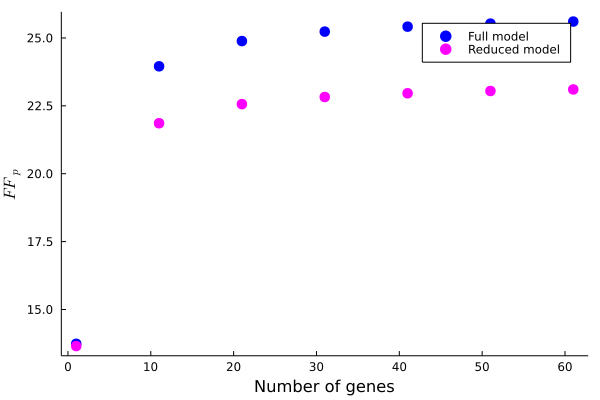

In [39]:
scatter(
    xs,
    ffs_full,
    label="Full model",
    markersize=6,
    markercolor=RGBA(0/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(0/255, 0/255, 255/255, 255/255),
)

scatter!(
    xs,
    ffs_red,
    label="Reduced model",
    xlabel="Number of genes",
    ylabel=L"FF_{p}",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false
)

In [40]:
savefig("../../data/figures-for-paper/rib_const_fano_factor_$(N)_copies_gene_IPI00136246.svg")

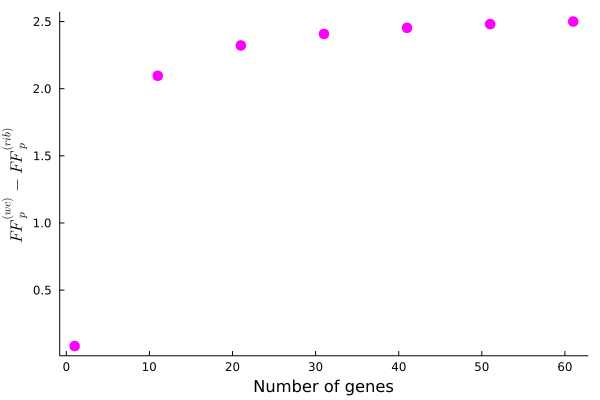

In [41]:
scatter(
    xs,
    ffs_full-ffs_red,
    ylabel=L"FF_p^{(wc)} - FF_p^{(rib)}",
    xlabel="Number of genes",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    legend=false,
    grid=false
)

In [42]:
savefig("../../data/figures-for-paper/rib_const_fano_factor_residual_$(N)_copies_gene_IPI00136246.svg")

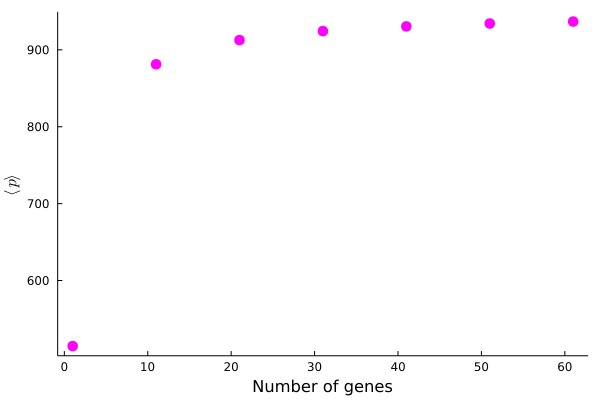

In [43]:
scatter(
    xs,
    p_mean_full,
    ylabel=L"\langle p \rangle",
    xlabel="Number of genes",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    legend=false,
    grid=false
)

In [44]:
savefig("../../data/figures-for-paper/rib_const_protein_copy_number_$(N)_copies_gene_IPI00136246.svg")

# Using an array of different genes.

In [ ]:
N = 10
rn = generate_rn(N)

ps = [10000*log(2)/1200., log(2)/1200.] # [ribosome production, ribosome degredation]
for j in 1:N
    ps = vcat(
        ps, 
        [
            rand(Normal(log(2)/210*5, 0.1*log(2)/210*5)), # mRNA creation
            rand(Normal(log(2)/210 + log(2)/1200, 0.1*log(2)/210 + log(2)/1200)), # mRNA degredation
            rand(Normal(.0001, 0.1*.0001)), # binding to polysome
            rand(Normal(0.0001, 0.00001)), # unbinding from polysome
            rand(Normal(0.1,0.01)), # translation,
            rand(Normal(log(2)/1200., 0.1*log(2)/1200.)), # monosome decay
            rand(Normal(log(2)/1200., 0.1*log(2)/1200)) # protein decay
        ]
    )
end

In [ ]:
prob = LNAProblem(rn, zeros(Int, 3*N+3), ps)

sol = solve(prob)

lnameans = mean(sol)
lnacovs = StatsBase.cov(sol)

initial_values = map(Int64, map(ceil, lnameans))

prob = DiscreteProblem(rn, initial_values, (0, 50000000.),  ps)
jump_prob = JumpProblem(rn, prob, Direct(), save_positions=(false, false))

sol = solve(jump_prob, SSAStepper(), saveat=1.0)
mrna_counts = map(x -> x[2], sol.u)
monosome_counts = map(x -> x[3], sol.u)
protein_counts = map(x -> x[4], sol.u)
ribosome_counts = map(x -> x[1], sol.u)

In [ ]:
prot_mean = lnameans[4]
prot_var = lnacovs[4,4]

p = prot_mean/prot_var
r = prot_var*p^2/(1-p)

nb = NegativeBinomial(r,p)
step = 100
xs_wc = [minimum(protein_counts):step:maximum(protein_counts)]
ys_wc = Distributions.pdf(nb, xs)

histogram(
    protein_counts, 
    nbins=maximum(protein_counts), 
    norm=true, 
    label="Simulation",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

scatter!(
    xs_wc,
    ys_wc, 
    label="LNA Approximation", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = RGBA(255/255, 0/255, 255/255, 255/255),
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false,
    markersize=4
)

In [44]:
rn_can = @reaction_network begin
    k1, 0 --> m
    k2, m --> 0
    k3, m --> m + p
    k6, p --> 0
end k1 k2 k3 k6

Model ##ReactionSystem#303 with 4 equations
States (2):
  m(t)
  p(t)
Parameters (4):
  k1
  k2
  k3
  k6

In [45]:
ps_can =[
    ps[3], # mRNA creation
    ps[4], # mRNA degredation
    ps[4]*ps[9]*lnameans[4]/ps[3], # translation,
    ps[9] # protein decay
]

4-element Vector{Float64}:
 0.017263809890141132
 0.00464761487347646
 0.4591424425538247
 0.00046514905570555816

In [46]:
prob = LNAProblem(rn_can, zeros(Int, 2), ps_can)

sol = solve(prob)

lnameans_can = mean(sol)
lnacovs_can = StatsBase.cov(sol)

initial_values = map(Int64, map(ceil, lnameans_can))

prob = DiscreteProblem(rn_can, initial_values, (0, 5000000.),  ps_can)
jump_prob = JumpProblem(rn_can, prob, Direct(), save_positions=(false, false))

sol = solve(jump_prob, SSAStepper(), saveat=1.0)
mrna_counts_can = map(x -> x[1], sol.u)
protein_counts_can = map(x -> x[2], sol.u)

5000001-element Vector{Int64}:
 3667
 3669
 3670
 3668
 3672
 3672
 3672
 3673
 3673
 3677
 3676
 3674
 3678
    ⋮
 2260
 2262
 2264
 2266
 2266
 2265
 2266
 2266
 2267
 2266
 2267
 2267

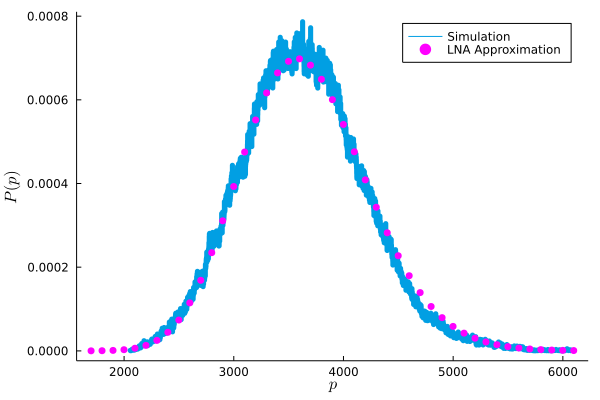

In [47]:
prot_mean = lnameans_can[2]
prot_var = lnacovs_can[2,2]

p = prot_mean/prot_var
r = prot_var*p^2/(1-p)

nb = NegativeBinomial(r,p)
step = 100
xs_can = [minimum(protein_counts):step:maximum(protein_counts)]
ys_can = Distributions.pdf(nb, xs)

histogram(
    protein_counts_can, 
    nbins=maximum(protein_counts), 
    norm=true, 
    label="Simulation",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

scatter!(
    xs_can,
    ys_can, 
    label="LNA Approximation", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = RGBA(255/255, 0/255, 255/255, 255/255),
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false,
    markersize=4
)

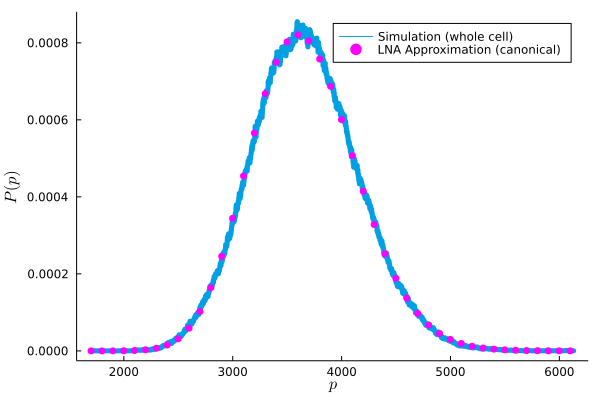

In [48]:
histogram(
    protein_counts, 
    nbins=maximum(protein_counts), 
    norm=true, 
    label="Simulation (whole cell)",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

scatter!(
    xs,
    ys, 
    label="LNA Approximation (canonical)", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = RGBA(255/255, 0/255, 255/255, 255/255),
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false,
    markersize=4
)

In [49]:
rn_single_rib = @reaction_network begin
    k1, 0 --> r
    k2, r --> 0
    k3, 0 --> m
    k4, m --> 0
    k5, m + r --> m + r + p
    k6, p --> 0
end k1 k2 k3 k4 k5 k6

Model ##ReactionSystem#306 with 6 equations
States (3):
  r(t)
  m(t)
  p(t)
Parameters (6):
  k1
  k2
  k3
  k4
  k5
  k6

In [50]:
ps_single_rib = [
    ps[1], # rib creation
    ps[2], # rib degredation
    ps[3], # mrna creation
    ps[4], # mrna degredation
    ps[4]*ps[2]*ps[2]*lnameans[4]/(ps[3]*ps[1]), # translation
    ps[2], # protein degredation = rib degredation
]

prob = LNAProblem(rn_single_rib, zeros(Int, 3), ps_single_rib)

sol = solve(prob)

lnameans_single_rib = mean(sol)
lnacovs_single_rib = StatsBase.cov(sol)

prot_mean = lnameans_single_rib[3]
prot_var = lnacovs_single_rib[3,3]

p = prot_mean/prot_var
r = prot_var*p^2/(1-p)

nb_single_rib = NegativeBinomial(r,p)
step = 100
xs_single_rib = [minimum(protein_counts):step:maximum(protein_counts)]
ys_single_rib = Distributions.pdf(nb_single_rib, xs)

1-element Vector{Vector{Float64}}:
 [6.032307804830384e-7, 1.5334098444059212e-6, 3.5309699053400026e-6, 7.439825763318747e-6, 1.4467748433854001e-5, 2.6159354043273524e-5, 4.426219487994222e-5, 7.047846279209742e-5, 0.00010613004689344185, 0.0001517990947201074  …  4.488390818217678e-5, 3.349567994236553e-5, 2.471063774194312e-5, 1.802848428938402e-5, 1.3013310638505411e-5, 9.296805349112194e-6, 6.575859778166592e-6, 4.606719453533911e-6, 3.197359950144939e-6, 2.199302866743413e-6]

In [51]:
rn_rib_bound = @reaction_network begin
    k1, 0 --> r
    k2, r --> 0
    k3, 0 --> m
    k4, m --> 0
    k5, m + r --> m + r + p
    k6, p --> 0
    k7, r --> rb
    k8, rb --> r
    k9, rb --> 0
end k1 k2 k3 k4 k5 k6 k7 k8 k9

Model ##ReactionSystem#307 with 9 equations
States (4):
  r(t)
  m(t)
  p(t)
  rb(t)
Parameters (9):
  k1
  k2
  k3
  k4
  k5
  k6
⋮

In [52]:
indexes = 5+7:7:length(ps)
length(ps)
rib_binding = sum(getindex(ps, indexes))
rib_unbinding = sum(getindex(ps, indexes .+ 1)) + sum(getindex(ps, indexes .+ 2))

0.8758811830399997

In [ ]:
ps_rib_bound = [
    ps[1], # rib creation
    ps[2], # rib degredation
    ps[3], # mrna creation
    ps[4], # mrna degredation
    ps[4]*ps[2]*ps[2]*lnameans[4]/(ps[3]*ps[1]), # translation
    ps[2], # protein degredation = rib degredation
    rib_binding, # rib binding
    rib_unbinding, # rib unbinding
    ps[2], # bound ribosome degredation
]

prob = LNAProblem(rn_single_rib, zeros(Int, 3), ps_rib_bound)

sol = solve(prob)

lnameans_rib_bound = mean(sol)
lnacovs_rib_bound = StatsBase.cov(sol)

prot_mean = lnameans_rib_bound[3]
prot_var = lnacovs_rib_bound[3,3]

p = prot_mean/prot_var
r = prot_var*p^2/(1-p)

nb_rib_bound = NegativeBinomial(r,p)
step = 100
xs_rib_bound = [minimum(protein_counts):step:maximum(protein_counts)]
ys_rib_bound = Distributions.pdf(nb_rib_bound, xs)

In [ ]:
histogram(
    protein_counts, 
    nbins=maximum(protein_counts), 
    norm=true, 
    label="Simulation (whole cell)",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

scatter!(
    xs_single_rib,
    ys_single_rib, 
    label="LNA Approximation (single rib)", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = RGBA(255/255, 0/255, 255/255, 255/255),
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false,
    markersize=4
)

scatter!(
    xs_can,
    ys_can, 
    label="LNA Approximation (canonical)", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = RGBA(125/255, 0/255, 255/255, 255/255),
    markerstrokecolor=RGBA(125/255, 0/255, 255/255, 255/255),
    grid=false,
    markersize=4
)

scatter!(
    xs_rib_bound,
    ys_rib_bound, 
    label="LNA Approximation (rib bound)", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = RGBA(125/255, 0/255, 125/255, 255/255),
    markerstrokecolor=RGBA(125/255, 0/255, 125/255, 255/255),
    grid=false,
    markersize=4
)

scatter!(
    xs_wc,
    ys_wc, 
    label="LNA Approximation (wc)", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = RGBA(125/255, 0/255, 125/255, 255/255),
    markerstrokecolor=RGBA(125/255, 0/255, 125/255, 255/255),
    grid=false,
    markersize=4
)

In [55]:
rn_rib_bound_int = @reaction_network begin
    k1, 0 --> r
    k2, r --> 0
    k3, 0 --> m
    k4, m --> 0
    k5, m + r --> rs
    k6, rs --> m + r
    k7, rs --> m + r + p
    k8, p --> 0
    k9, rs --> 0 
    k10, r --> rb
    k11, rb --> r
    k12, rb --> 0
end k1 k2 k3 k4 k5 k6 k7 k8 k9 k10 k11 k12

Model ##ReactionSystem#309 with 12 equations
States (5):
  r(t)
  m(t)
  rs(t)
  p(t)
  rb(t)
Parameters (12):
  k1
  k2
  k3
  k4
  k5
  k6
⋮

In [56]:
indexes = 5+7:7:length(ps)
length(ps)
rib_binding = sum(getindex(ps, indexes))
rib_unbinding = sum(getindex(ps, indexes .+ 1)) + sum(getindex(ps, indexes .+ 2))

0.8758811830399997

In [57]:
species(rn_rib_bound_int)

5-element Vector{Term{Real, Base.ImmutableDict{DataType, Any}}}:
 r(t)
 m(t)
 rs(t)
 p(t)
 rb(t)

In [58]:
ps_rib_bound = [
    ps[1], # rib creation
    ps[2], # rib degredation
    ps[3], # mrna creation
    ps[4], # mrna degredation
    ps[5],# rib binding
    ps[6],# rib unbinding
    ps[7], # translation
    ps[2], # protein degredation = rib degredation
    ps[2], # monosome degredation
    rib_binding, # rib binding
    rib_unbinding, # rib unbinding
    ps[2], # bound ribosome degredation
]

prob = LNAProblem(rn_rib_bound_int, ones(Int, 5) ./2, ps_rib_bound)

sol = solve(prob)

lnameans_rib_bound_int = mean(sol)
lnacovs_rib_bound_int = StatsBase.cov(sol)

prot_mean = lnameans_rib_bound_int[4]
prot_var = lnacovs_rib_bound_int[4,4]

p = prot_mean/prot_var
r = prot_var*p^2/(1-p)

nb_rib_bound_int = NegativeBinomial(r,p)
step = 100
xs_rib_bound_int = [minimum(protein_counts):step:maximum(protein_counts)]
ys_rib_bound_int = Distributions.pdf(nb_rib_bound, xs)

1-element Vector{Vector{Float64}}:
 [6.032307804830384e-7, 1.5334098444059212e-6, 3.5309699053400026e-6, 7.439825763318747e-6, 1.4467748433854001e-5, 2.6159354043273524e-5, 4.426219487994222e-5, 7.047846279209742e-5, 0.00010613004689344185, 0.0001517990947201074  …  4.488390818217678e-5, 3.349567994236553e-5, 2.471063774194312e-5, 1.802848428938402e-5, 1.3013310638505411e-5, 9.296805349112194e-6, 6.575859778166592e-6, 4.606719453533911e-6, 3.197359950144939e-6, 2.199302866743413e-6]

In [ ]:
histogram(
    protein_counts, 
    nbins=maximum(protein_counts), 
    norm=true, 
    label="Simulation (whole cell)",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

scatter!(
    xs_single_rib,
    ys_single_rib, 
    label="LNA Approximation (single rib)", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = RGBA(255/255, 0/255, 255/255, 255/255),
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false,
    markersize=4
)

scatter!(
    xs_can,
    ys_can, 
    label="LNA Approximation (canonical)", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = RGBA(125/255, 0/255, 255/255, 255/255),
    markerstrokecolor=RGBA(125/255, 0/255, 255/255, 255/255),
    grid=false,
    markersize=4
)

scatter!(
    xs_rib_bound_int,
    ys_rib_bound_int, 
    label="LNA Approximation (rib bound int)", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = RGBA(125/255, 0/255, 125/255, 255/255),
    markerstrokecolor=RGBA(125/255, 0/255, 125/255, 255/255),
    grid=false,
    markersize=4
)

scatter!(
    xs_rib_bound,
    ys_rib_bound, 
    label="LNA Approximation (rib bound)", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = RGBA(125/255, 0/255, 0/255, 255/255),
    markerstrokecolor=RGBA(125/255, 0/255, 0/255, 255/255),
    grid=false,
    markersize=4
)

In [62]:
lnameans_rib_bound_int

u: 5-element Vector{Float64}:
 9972.859752906978
    1.6333963026551592
   16.74521061773773
 2754.105996164494
   10.395036475282193

In [63]:
species(rn_rib_bound_int)

5-element Vector{Term{Real, Base.ImmutableDict{DataType, Any}}}:
 r(t)
 m(t)
 rs(t)
 p(t)
 rb(t)

In [64]:
condition = lnameans_rib_bound_int[3]/(lnameans_rib_bound_int[1]+lnameans_rib_bound_int[3]+lnameans_rib_bound_int[5])

0.0016745210617737736